<a href="https://colab.research.google.com/github/kvnptl/pytorch-practice/blob/main/01_pytorch_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 01. PyTorch Workflow

[1] My Github repo: https://github.com/kvnptl/pytorch-practice

[2] Reference Video: https://www.youtube.com/watch?v=Z_ikDlimN6A&t=83869s 

[3] Reference Book: https://www.learnpytorch.io/00_pytorch_fundamentals/#creating-tensors 



# Content

- Data (prepare and load)
- Build a model
- Fitting the data to model (training)
- Making prediction and evaluating a model (inference)
- Saving and loading model

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
print(torch.__version__)

2.0.1+cu117


### Linear regression 

In [2]:
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], X.shape, len(X)

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 torch.Size([50, 1]),
 50)

In [3]:
y[:10], y.shape, len(y)

(tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]),
 torch.Size([50, 1]),
 50)

#### Split the data

In [4]:
train_split = int(0.8 * len(X)) # 80% of the data for training
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(X_test), len(X_train), len(X_test)

(40, 10, 40, 10)

In [5]:
def plot_predictions (train_data=X_train, 
                      train_labels=y_train,
                      test_data = X_test,
                      test_labels=y_test,
                      predictions=None):
  '''
  Plot training data, test data, and compares predictions
  '''

  plt.figure(figsize=(10,7))

  plt.scatter(train_data, train_labels, c='b', s=4, label="Training data") # c: color, s: size

  plt.scatter(test_data, test_labels, c='g', s=4, label="Test data")

  if predictions is not None:
    plt.scatter(test_data, predictions, c='r', s= 4, label="Predictions")

  plt.legend(prop={"size":14})



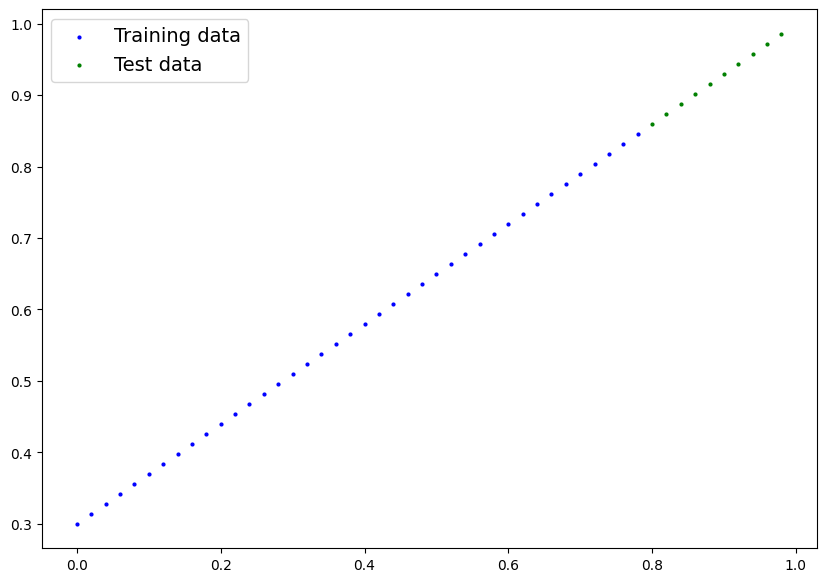

In [6]:
plot_predictions();

### Build a model

- `nn.Module` contains the larger building blocks (layers)

- `nn.Parameter` contains the smaller parameters like weights and biases (put these together to make nn.Module(s))

- `forward()` tells the larger blocks how to make calculations on inputs (tensors full of data) within nn.Module(s)

- `torch.optim` contains optimization methods on how to improve the parameters within nn.Parameter to better represent input data

In [7]:
class LinearRegressionModel(nn.Module): # almost everything in Pytorch inherits from nn module
  
  def __init__(self):
    super().__init__() # super() is used to call the __init__() of the parent class
    # super(LinearRegressionModel, self).__init__() # another way to call the __init__() of the parent class
    
    self.weights = nn.Parameter(torch.randn(1,
                                            requires_grad=True,
                                            dtype=torch.float))
    self.bias = nn.Parameter(torch.randn(1,
                                         requires_grad=True,
                                         dtype=torch.float))
    
  def forward(self, x: torch.Tensor) -> torch.Tensor: # x is input data
    return self.weights * x + self.bias



In [8]:
torch.manual_seed(42)
torch.randn(1)

tensor([0.3367])

In [9]:
# random seed
torch.manual_seed(42) 

model_0 = LinearRegressionModel()

list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [10]:
model_0.state_dict() # state_dict() returns the weights and biases of the model

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [11]:
# Original weights and biases 
weight, bias

(0.7, 0.3)

#### PyTorch inference model reference - [Link](https://twitter.com/pytorch/status/1437838231505096708)

In [12]:
with torch.inference_mode(): # inference_mode() is used to turn off gradient calculation
  y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

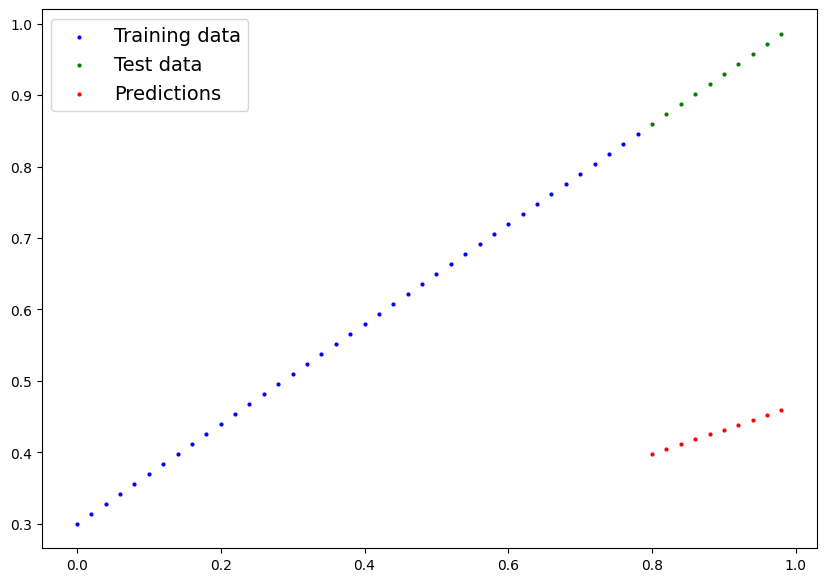

In [13]:
plot_predictions(predictions=y_preds)

### Train model


- **Loss function**: also known as criterion 

In [14]:
# loss function

loss_fn = nn.L1Loss() # Mean Absolute Error (MAE)

# an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01)

In [15]:
epochs = 500

epoch_count = []
loss_values = []
test_loss_values = []

for epoch in range(epochs):
  # set the model to training mode
  model_0.train() # train model sets all parameters that require gradients to require gradients 

  # Forward pass
  y_pred = model_0(X_train)

  # Loss
  loss = loss_fn(y_pred, y_train)
  # print(f'Loss: {loss}')

  # optimizer
  optimizer.zero_grad() # to avoid accumulation of gradients 

  # backward pass
  loss.backward() # calculate the gradients

  # step the optimizer (perform gradient descent) 
  # update the parameters
  optimizer.step()

  # Testing
  with torch.inference_mode(): # turn off gradient tracking and more
    # forward pass
    test_pred =  model_0(X_test)

    # calculate the loss
    test_loss = loss_fn(test_pred, y_test)

  if epoch % 10 == 0:
    epoch_count.append(epoch)
    loss_values.append(loss.detach().numpy()) # detach() is used to remove the tensor from the computation graph
    # if you don't use detach(), the loss will be stored in the computation graph and will be used to calculate the gradients
    test_loss_values.append(test_loss.detach().numpy()) 
    print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")
    # print(model_0.state_dict())

Epoch: 0 | Loss: 0.31288138031959534 | Test loss: 0.48106518387794495
Epoch: 10 | Loss: 0.1976713240146637 | Test loss: 0.3463551998138428
Epoch: 20 | Loss: 0.08908725529909134 | Test loss: 0.21729660034179688
Epoch: 30 | Loss: 0.053148526698350906 | Test loss: 0.14464017748832703
Epoch: 40 | Loss: 0.04543796554207802 | Test loss: 0.11360953003168106
Epoch: 50 | Loss: 0.04167863354086876 | Test loss: 0.09919948130846024
Epoch: 60 | Loss: 0.03818932920694351 | Test loss: 0.08886633068323135
Epoch: 70 | Loss: 0.03476089984178543 | Test loss: 0.0805937647819519
Epoch: 80 | Loss: 0.03132382780313492 | Test loss: 0.07232122868299484
Epoch: 90 | Loss: 0.02788739837706089 | Test loss: 0.06473556160926819
Epoch: 100 | Loss: 0.024458957836031914 | Test loss: 0.05646304413676262
Epoch: 110 | Loss: 0.021020207554101944 | Test loss: 0.04819049686193466
Epoch: 120 | Loss: 0.01758546568453312 | Test loss: 0.04060482233762741
Epoch: 130 | Loss: 0.014155393466353416 | Test loss: 0.03233227878808975
Ep

In [16]:
model_0.state_dict()
# Note: the weights and biases are close to the original weights and biases

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

[]

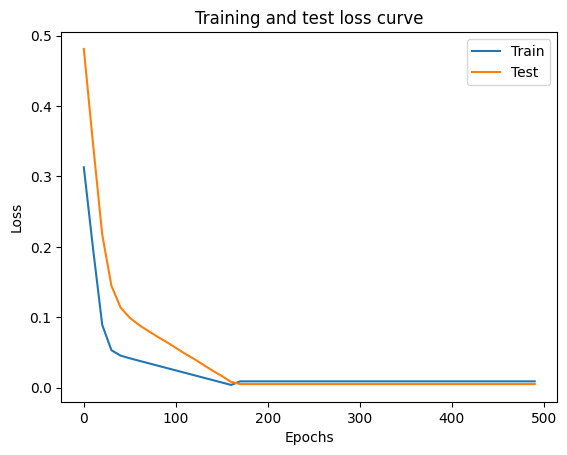

In [17]:
# Plot the loss curve
plt.plot(epoch_count, loss_values, label='Train')
plt.plot(epoch_count, test_loss_values, label="Test")
plt.title("Training and test loss curve")
plt.xlabel("Epochs")
plt.ylabel('Loss')
plt.legend()
plt.plot()

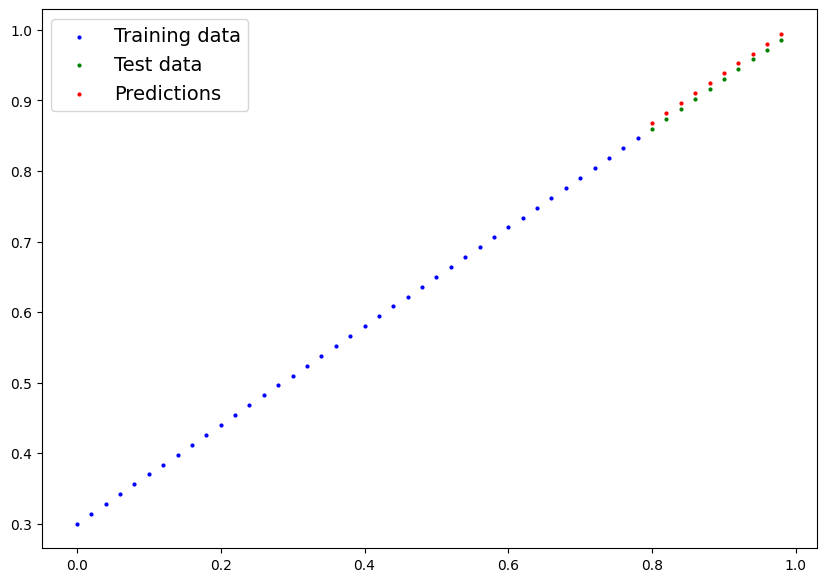

In [18]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)

plot_predictions(predictions=y_preds_new)

### Saving a Model

- `torch.save()` - save a pytorch object in a pickle format
- `torch.load()` - load saved pytorch object
- `torch.nn.Module.load_state_dict()` - loads a model's saved state dictionary

In [21]:
from pathlib import Path

# create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True) # parents=True creates parent directories if they don't exist and exist_ok=True doesn't raise an error if the directory already exists

# save path
MODEL_NAME = '0.1_pytorch_workflow.pt'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# save model dict
torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH) # obj is the object to be saved and f is the path to the file

### Load a model

In [22]:
loaded_model_0 = LinearRegressionModel()

# load the saved model
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH)) # load_state_dict() loads the saved model
# Note: here we are loading only the weights and biases of the model and not the entire model

<All keys matched successfully>

In [23]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [24]:
# NOTE: eval() and inference_mode() are used to turn off gradient tracking and more to speed up the model inference
# inference_mode() is more efficient than eval() as it turns off more things than eval()
with torch.inference_mode(): # turn off gradient tracking and more
  loaded_model_preds = loaded_model_0(X_test)

loaded_model_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

## Putting it all together

In [25]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

### Data loading

In [26]:
X = torch.arange(start=0, end=1, step=0.02).unsqueeze(dim=1)

weights = 0.3
bias = 0.6

y = weights * X + bias

print(f'Total data size: {len(X)}')


Total data size: 50


In [27]:
samples = int(0.8*len(X))

x_train, y_train = X[:samples], y[:samples]
x_test, y_test = X[samples:], y[samples:]

print(f'Data split size | train: {len(x_train)} | test: {len(x_test)}')

Data split size | train: 40 | test: 10


In [28]:
def plot_predictions (train_data=x_train, 
                      train_labels=y_train,
                      test_data = x_test,
                      test_labels=y_test,
                      predictions=None):
  '''
  Plot training data, test data, and compares predictions
  '''

  plt.figure(figsize=(10,7))

  plt.scatter(train_data, train_labels, c='b', s=4, label="Training data")

  plt.scatter(test_data, test_labels, c='g', s=4, label="Test data")

  if predictions is not None:
    plt.scatter(test_data, predictions, c='r', s= 4, label="Predictions")

  plt.legend(prop={"size":14})

### Plot input data

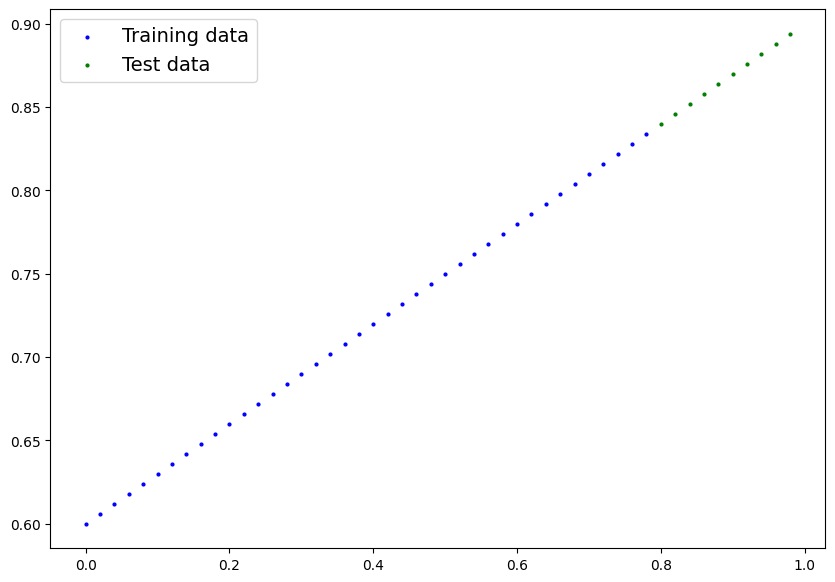

In [29]:
plot_predictions()

### Model

In [30]:
# class LinearRegressionModel_00(nn.Module):

#   def __init__(self):
#     super().__init__()

#     self.weights = nn.Parameter(torch.randn(1,
#                                 requires_grad=True))
    
#     self.bias = nn.Parameter(torch.randn(1,
#                                          requires_grad=True))
    
#   def forward(self, x):
#     return self.weights * x + self.bias


In [31]:
class LinearRegressionModel_00(nn.Module):

  def __init__(self):
    super().__init__()

    # linear transformation y=aX+b, and also set weights and biases by default
    self.linear_layer = nn.Linear(in_features=1,
                                  out_features=1)
    
  def forward(self, x):
    return self.linear_layer(x)

In [32]:
torch.manual_seed(42)

model_00 = LinearRegressionModel_00()

model_00.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
             ('linear_layer.bias', tensor([0.8300]))])

In [33]:
loss_fn_00 = nn.L1Loss()

optimizer_00 = torch.optim.SGD(model_00.parameters(), 
                               lr = 0.01)

### Train

In [34]:
epochs = 500

epoch_count = []
loss_values = []
test_loss_values = []

for epoch in range(epochs):
  model_00.train()

  y_pred = model_00(x_train)

  loss = loss_fn_00(y_pred, y_train)

  optimizer_00.zero_grad()

  loss.backward()

  optimizer_00.step()

  #test
  with torch.inference_mode():
    test_pred = model_00(x_test)

    # loss
    test_loss = loss_fn_00(test_pred, y_test)


  if epoch % 10 == 0:
    print(f"Loss: {loss} | test_loss = {test_loss}")
    epoch_count.append(epoch)
    loss_values.append(loss.detach().numpy())
    test_loss_values.append(test_loss.detach().numpy())


Loss: 0.41117793321609497 | test_loss = 0.629976212978363
Loss: 0.29596802592277527 | test_loss = 0.4952663481235504
Loss: 0.18075816333293915 | test_loss = 0.36055654287338257
Loss: 0.09276367723941803 | test_loss = 0.24520985782146454
Loss: 0.06624828279018402 | test_loss = 0.1814330518245697
Loss: 0.058458346873521805 | test_loss = 0.14907316863536835
Loss: 0.05426899716258049 | test_loss = 0.13129112124443054
Loss: 0.05077900364995003 | test_loss = 0.12027108669281006
Loss: 0.047298990190029144 | test_loss = 0.10993792861700058
Loss: 0.04386298730969429 | test_loss = 0.10166557133197784
Loss: 0.040425464510917664 | test_loss = 0.09408005326986313
Loss: 0.03699700906872749 | test_loss = 0.0858076959848404
Loss: 0.03355933725833893 | test_loss = 0.07753533869981766
Loss: 0.030123483389616013 | test_loss = 0.06994982063770294
Loss: 0.026694511994719505 | test_loss = 0.061677463352680206
Loss: 0.023255692794919014 | test_loss = 0.053405094891786575
Loss: 0.019821500405669212 | test_los

### Plot

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[]

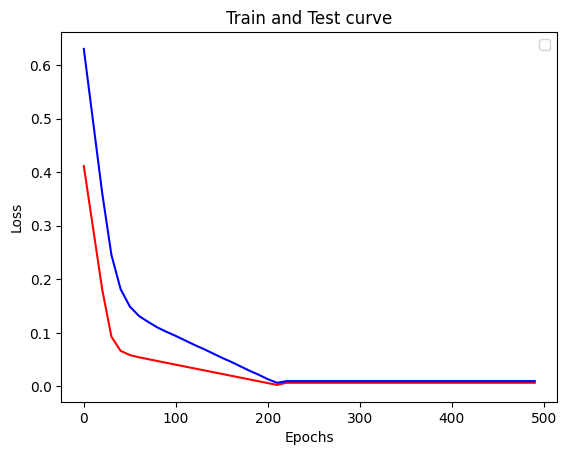

In [35]:
# plot train and test curve

plt.plot(epoch_count, loss_values, c='r')
plt.plot(epoch_count, test_loss_values, c='b')
plt.title("Train and Test curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.plot()

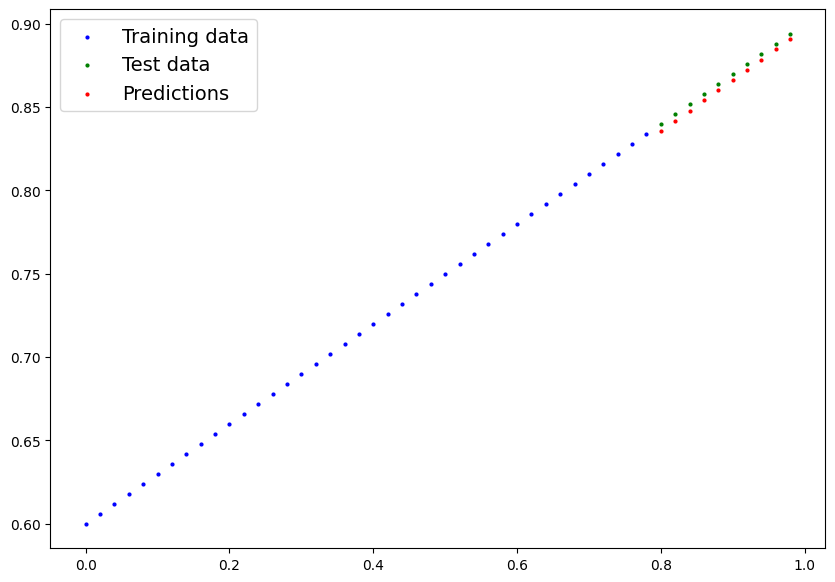

In [36]:
plot_predictions(predictions=test_pred)

### Save model

In [37]:

MODEL_PATH = Path('models', )
MODEL_PATH.mkdir(parents=True, exist_ok=True)
MODEL_NAME = "01_pytorch_workflow_00.pt"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

torch.save(model_00.state_dict(), MODEL_SAVE_PATH)

 

### Load model

In [38]:
loaded_model_00 = LinearRegressionModel_00()

loaded_model_00.load_state_dict(torch.load(MODEL_SAVE_PATH))

loaded_model_00.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.3059]])),
             ('linear_layer.bias', tensor([0.5910]))])

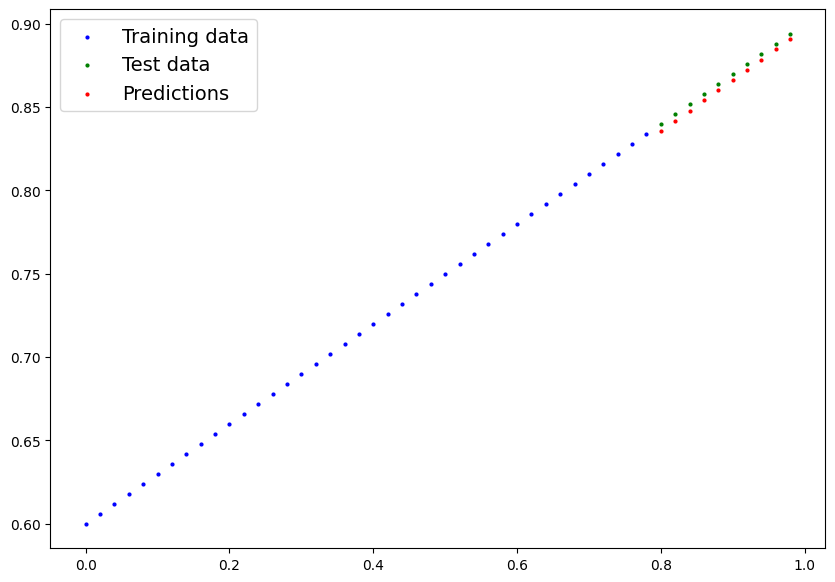

In [39]:
with torch.inference_mode():
  loaded_model_00_pred = loaded_model_00(x_test)

plot_predictions(predictions=loaded_model_00_pred)

# End